# Proposal Flare Comparison

This notebook recomputes the simulated MOXSI observation for the flaring case from Figure 9 of the HFORT proposal

In [1]:
import numpy as np
import astropy.units as u
import astropy.time
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.coordinates import get_horizons_coord, Helioprojective
import ndcube
from scipy.io import readsav
from astropy.visualization import ImageNormalize, LogStretch, AsinhStretch, AsymmetricPercentileInterval, quantity_support
import astropy.wcs
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import distributed

from overlappy.io import read_overlappogram
from overlappy.util import color_lat_lon_axes

from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import ThinFilmFilter
from mocksipipeline.detector.component import DispersedComponent
from mocksipipeline.util import stack_components

from synthesizAR.instruments.util import extend_celestial_wcs

In [2]:
line_ids = [
    ('Fe XVIII',14.21*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 15.01*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 16.78*u.AA),
    ('Fe XVII', 17.05*u.AA),
    ('O VII', 21.60*u.angstrom),  # also targeted by MaGIXS
    ('O VII', 21.81*u.angstrom),
    ('O VII', 22.10*u.AA),
    ('O VIII', 18.97*u.angstrom),  # also targeted by MaGIXS
    ('Fe XXV', 1.86*u.AA),
    ('Ca XIX', 3.21*u.AA),
    ('Si XIII', 6.74*u.AA),
    ('Mg XI', 9.32*u.AA),
    ('Fe XVII', 11.25*u.AA),
    ('Fe XX', 12.83*u.AA),
    ('Ne IX', 13.45*u.AA),
    ('Fe XIX', 13.53*u.AA),
    ('C VI', 33.73*u.AA),
    ('C V', 40.27*u.AA),
    ('Si XII', 44.16*u.AA),
    ('Si XI', 49.18*u.AA),
]

In [3]:
def add_line_ids_to_axis(ax, line_ids, rotation=90, line_unit=None):
    for ion,line in line_ids:
        ax.axvline(x=line.to_value(line_unit), ls=':', color='k',)
    ax2 = ax.secondary_xaxis('top') 
    ax2.set_xticks(u.Quantity([l for _,l in line_ids]).to_value(line_unit),
                   labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
                   rotation=rotation,
                   horizontalalignment='center',
                   #verticalalignment='center'
                  )

In [4]:
def get_norm_from_percentile(data, lower_percentile=1, upper_percentile=99, unit=None, stretch=LogStretch()):
    interval = AsymmetricPercentileInterval(lower_percentile, upper_percentile)
    if unit is None:
        unit = data.unit
    vmin,vmax = interval.get_limits(data.to_value(unit))
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
    return norm

## Load EM Distribution

In [5]:
file_struct = readsav('../../athiray_data/flare_emcube_proposal.sav')
scale_factor = 1e26 * u.cm**(-5)  # This scaling factor is from Athiray
date_obs = astropy.time.Time('2011-02-15 01:55:00')  # This time is from Athiray
em_data = file_struct['emcube'] * scale_factor
inversion_status = file_struct['statuscube']
temperature_bin_centers = 10**file_struct['lgtaxis'] * u.K

We need to replace some of the bad pixels in the EM inversion

In [217]:
kernel = Gaussian2DKernel(x_stddev=1)
em_data_fixed = []
#bad_inversion = np.logical_or(inversion_status==10, inversion_status==2)
bad_inversion = inversion_status != 0
#bad_inversion = em_data.sum(axis=0) == 0.0
for em_slice in em_data.to_value('cm-5'):
    em_slice_with_nans = np.where(bad_inversion, np.nan, em_slice)
    em_slice_fixed = interpolate_replace_nans(em_slice_with_nans, kernel,)
    em_data_fixed.append(em_slice_fixed)
em_data_fixed = u.Quantity(np.array(em_data_fixed), 'cm-5')
# Fill the remaining NaNs with zeros
em_data_fixed[np.isnan(em_data_fixed)] = 0.0

In [218]:
observer_coordinate = get_horizons_coord('SDO', time=date_obs)
hpc_frame = Helioprojective(obstime=observer_coordinate.obstime, observer=observer_coordinate)

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


In [219]:
celestial_header = sunpy.map.header_helper.make_fitswcs_header(
    em_data.shape[1:],
    SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=hpc_frame),
    unit=em_data.unit,
    rotation_angle=0*u.deg,
    scale=(5.66,5.66)*u.arcsec/u.pix,  # I am assuming this based on 
)
celestial_wcs = astropy.wcs.WCS(header=celestial_header)
full_wcs = extend_celestial_wcs(celestial_wcs, temperature_bin_centers, 'temperature', 'phys.temperature')

In [220]:
em_cube = ndcube.NDCube(em_data_fixed, full_wcs)

In [221]:
norm = ImageNormalize(vmin=1e25, vmax=1e28, stretch=LogStretch())

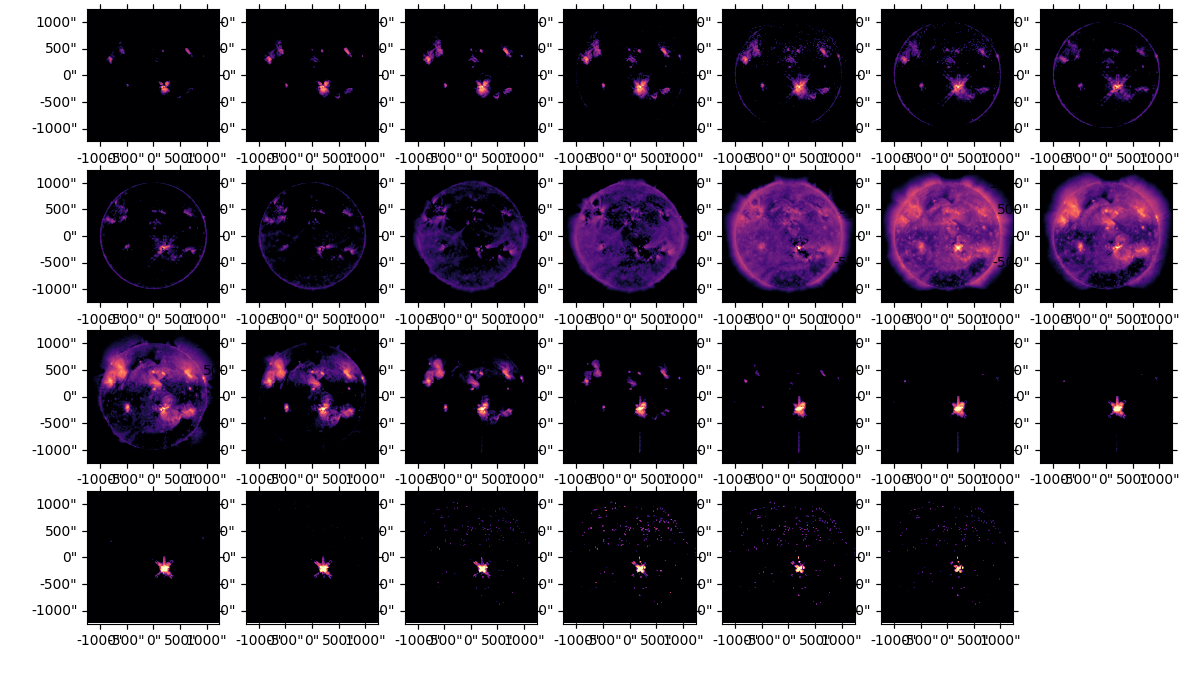

In [19]:
fig = plt.figure(figsize=(14,8))
for i,em in enumerate(em_cube):#[:, 150:220,220:290]):
    ax = fig.add_subplot(4,7,i+1, projection=em)
    em.plot(axes=ax, norm=norm, cmap='magma')
    ax.coords[0].set_axislabel(' ')
    ax.coords[1].set_axislabel(' ')

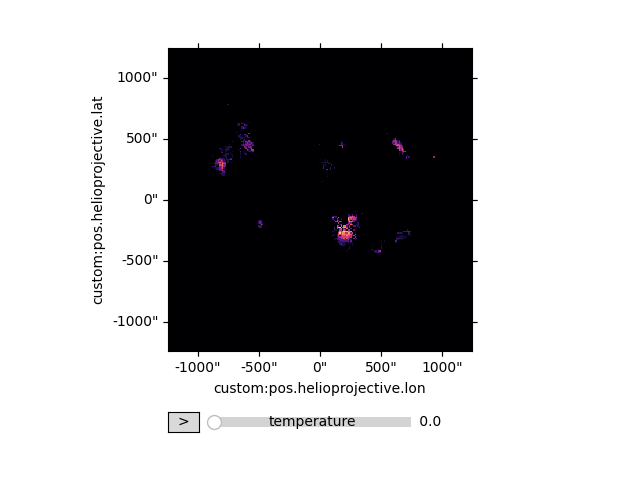

In [222]:
em_cube.plot(norm=norm, cmap='magma')

In [ ]:
em_cube.plot()

In [21]:
em_flare_summed = em_cube[:, 150:220,220:290].data.sum(axis=(1,2))

In [22]:
from fiasco.io import Parser
tab_flare = Parser('flare.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
tab_flare_ext = Parser('flare_ext.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()

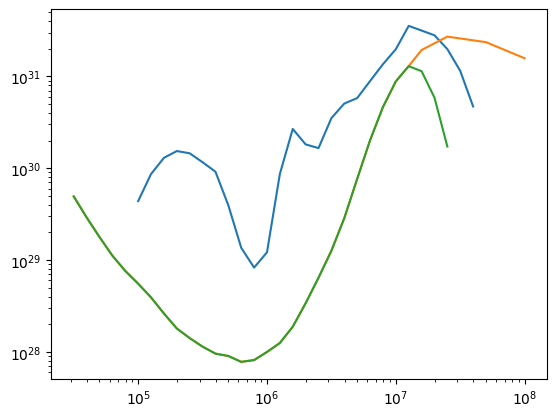

In [23]:
plt.plot(em_cube.axis_world_coords(0)[0], em_flare_summed)
plt.plot(tab_flare_ext['temperature_bin_center'], tab_flare_ext['dem']*np.gradient(tab_flare_ext['temperature_bin_center']))
plt.plot(tab_flare['temperature_bin_center'], tab_flare['dem']*np.gradient(tab_flare['temperature_bin_center']))
plt.yscale('log')
plt.xscale('log')

## Compute Spectral Cube

In [24]:
spec_model = SpectralModel()

In [25]:
spec_cube = spec_model.run(em_cube, celestial_wcs)

In [176]:
%matplotlib inline

In [177]:
iy,ix_upper = spec_cube[0].wcs.world_to_array_index(flare_upper)
_,ix_lower = spec_cube[0].wcs.world_to_array_index(flare_lower)

<WCSAxesSubplot:>

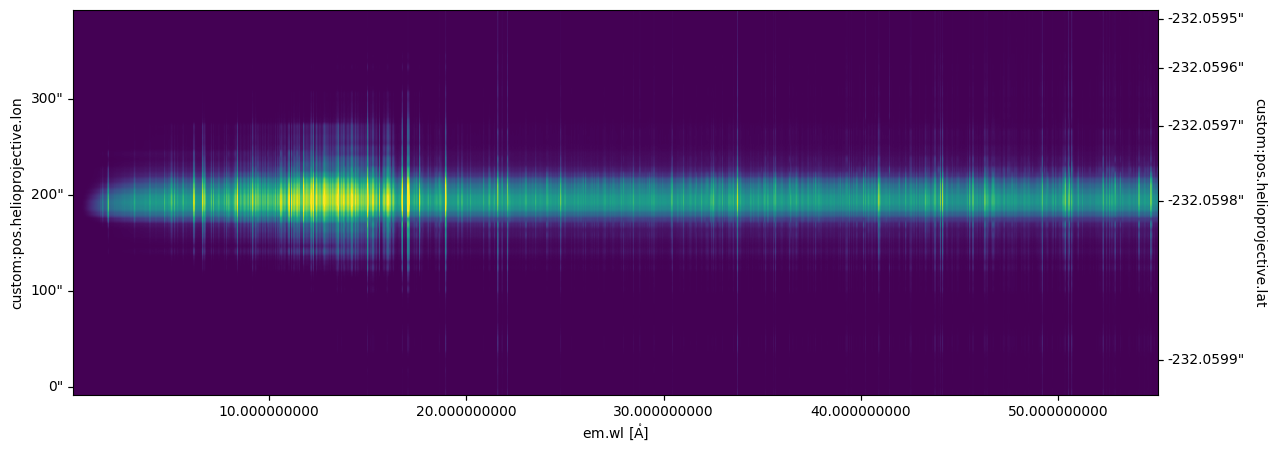

In [182]:
fig = plt.figure(figsize=(15,5))
flare_slice = np.s_[:1000,iy,ix_upper:ix_lower+1]
ax = fig.add_subplot(projection=spec_cube[flare_slice])
spec_cube[flare_slice].plot(
    axes=ax,
    norm=ImageNormalize(vmin=1e10, vmax=3e15, stretch=LogStretch()),
    aspect=5,
    plot_axes=('x','y'),
    axes_units=('Angstrom','arcsecond','arcsecond',),
)

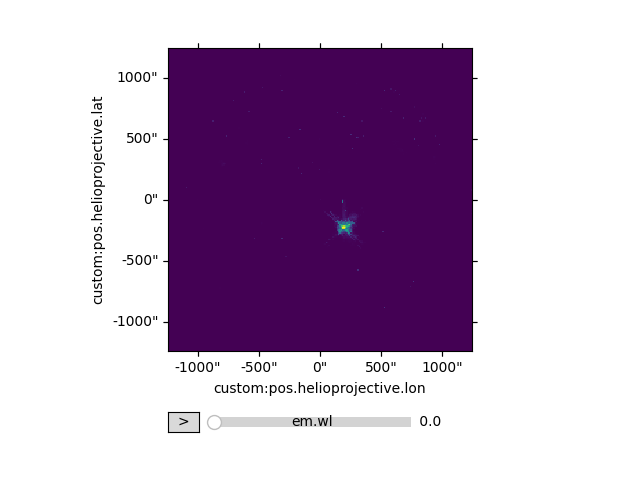

In [189]:
spec_cube[100:250].plot(norm=ImageNormalize(vmin=1e8, vmax=1e14, stretch=LogStretch()))

## Compute Overlappogram

In [26]:
client = distributed.Client()

2023-03-23 10:24:35,668 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-oodx2qon', purging
2023-03-23 10:24:35,668 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-g04uqyw0', purging
2023-03-23 10:24:35,669 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-u32je93j', purging
2023-03-23 10:24:35,669 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-pdn08j20', purging
2023-03-23 10:24:35,669 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-worker-space/worker-ivp25c5q', purging


In [252]:
client.close()

In [27]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')

In [28]:
dc = DispersedComponent(al_filter)

In [29]:
overlappograms = dc.compute(spec_cube, include_gain=False, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *ar

In [30]:
overlappograms

{-3: <ndcube.ndcube.NDCube object at 0x608560df0>
 NDCube
 ------
 Dimensions: [1238. 1500. 2000.] pix
 Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
 Unit: ph / (pix s)
 Data Type: float64,
 -1: <ndcube.ndcube.NDCube object at 0x608559df0>
 NDCube
 ------
 Dimensions: [1238. 1500. 2000.] pix
 Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
 Unit: ph / (pix s)
 Data Type: float64,
 0: <ndcube.ndcube.NDCube object at 0x67cca4dc0>
 NDCube
 ------
 Dimensions: [1238. 1500. 2000.] pix
 Physical Types of Axes: [('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos

In [31]:
total_overlappogram = stack_components([v for _,v in overlappograms.items()], wcs_index=2)

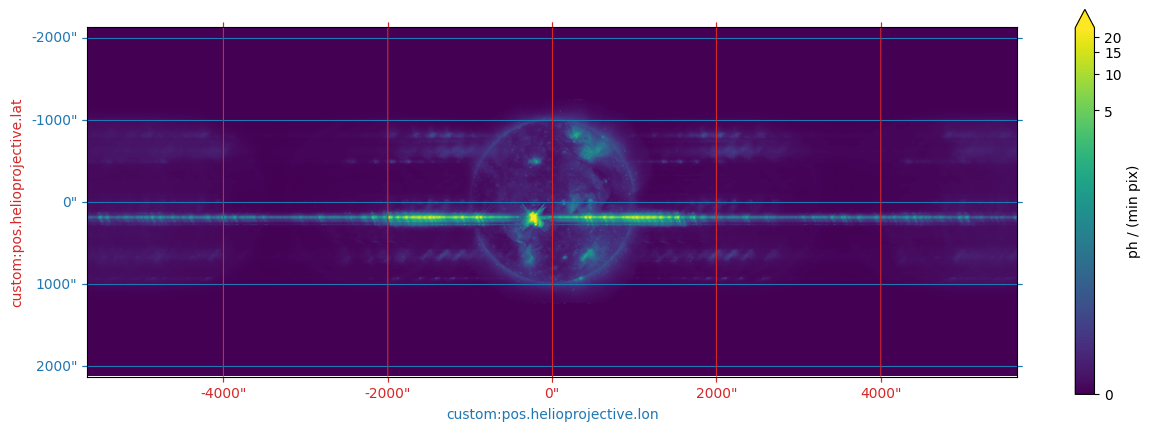

In [183]:
data_unit = u.Unit('photon / (pix minute)')

fig = plt.figure(figsize=(15,5))
cropped_cube = total_overlappogram[0,:751,:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.99, lower_percentile=0, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

In [185]:
%matplotlib widget

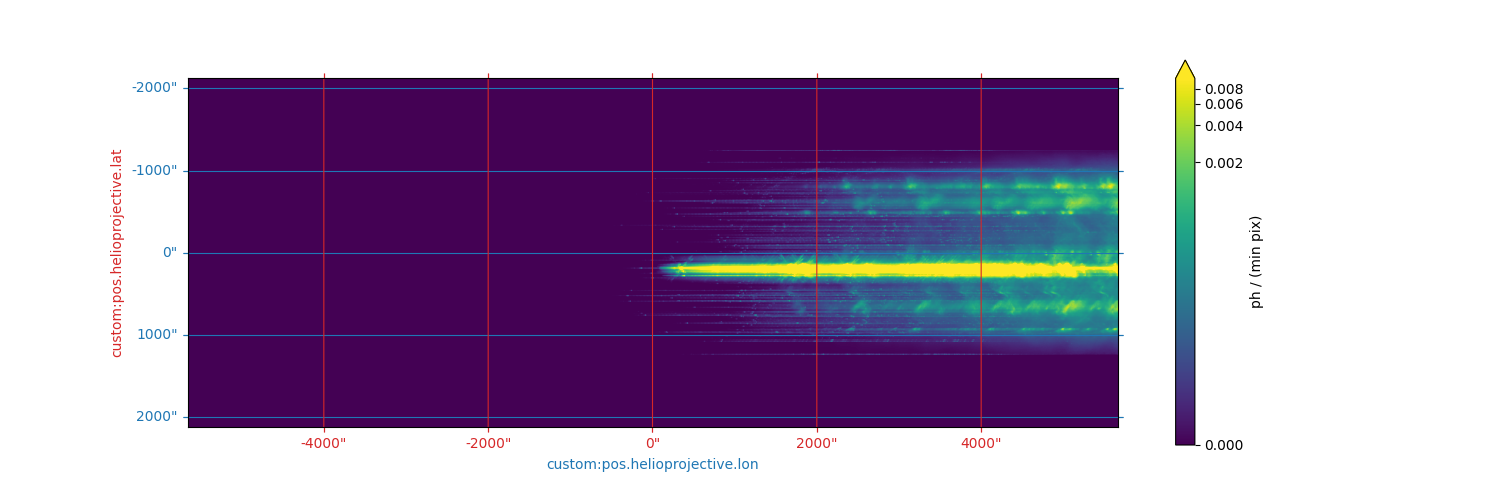

In [188]:
data_unit = u.Unit('photon / (pix minute)')

fig = plt.figure(figsize=(15,5))
cropped_cube = overlappograms[3][0,:751,:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99, lower_percentile=0, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

In [81]:
#flare_loc = SkyCoord(Tx=195*u.arcsec, Ty=-230*u.arcsec, frame=astropy.wcs.utils.wcs_to_celestial_frame(total_overlappogram.wcs))
#px, py = total_overlappogram[0].wcs.world_to_pixel(flare_loc)

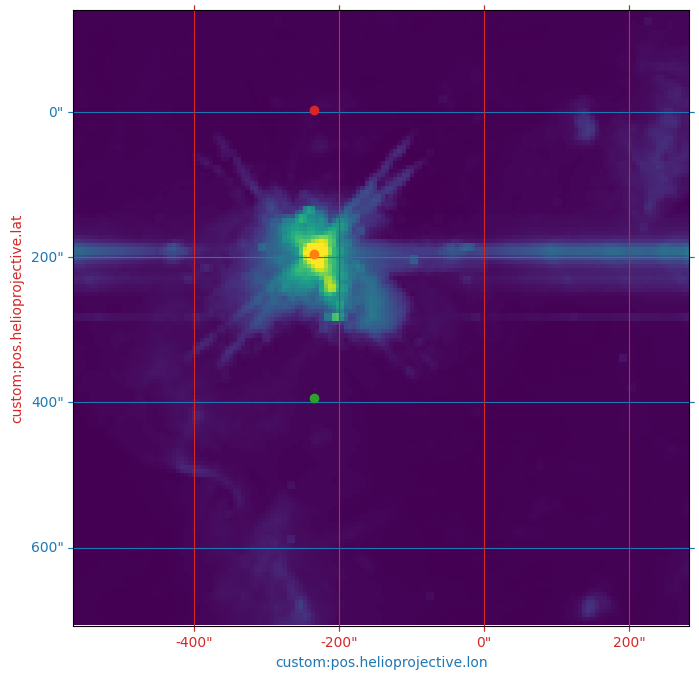

In [241]:
fig = plt.figure(figsize=(8,8))
cropped_cube = total_overlappogram[0,250:400,900:1050]

py,px = np.unravel_index(cropped_cube.data.argmax(), cropped_cube.data.shape)
flare_loc = cropped_cube.wcs.pixel_to_world(px, py)
flare_lower = cropped_cube.wcs.pixel_to_world(px, py-35)
flare_upper = cropped_cube.wcs.pixel_to_world(px, py+35)

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.9, lower_percentile=0, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax,
                   lat_tick_ops={'spacing': 200*u.arcsec, 'exclude_overlapping':True},
                   lon_tick_ops={'spacing': 200*u.arcsec, 'exclude_overlapping':True},)
ax.plot_coord(flare_loc, color='C1', marker='o')
ax.plot_coord(flare_lower, color='C2', marker='o')
ax.plot_coord(flare_upper, color='C3', marker='o')

In [242]:
wavelength_world = total_overlappogram.axis_world_coords(0)[0]

What am I trying to do here?

- I want to specify a cutout region in pixel space
- Then I want to know the wavelengths that correspond to that cutout
- I've specified a position

In [243]:
px,py,_ = overlappograms[1].wcs.world_to_pixel(flare_loc, wavelength_world)
px_lower,py_lower,_ = overlappograms[1].wcs.world_to_pixel(flare_lower, wavelength_world)
px_upper,py_upper,_ = overlappograms[1].wcs.world_to_pixel(flare_upper, wavelength_world)

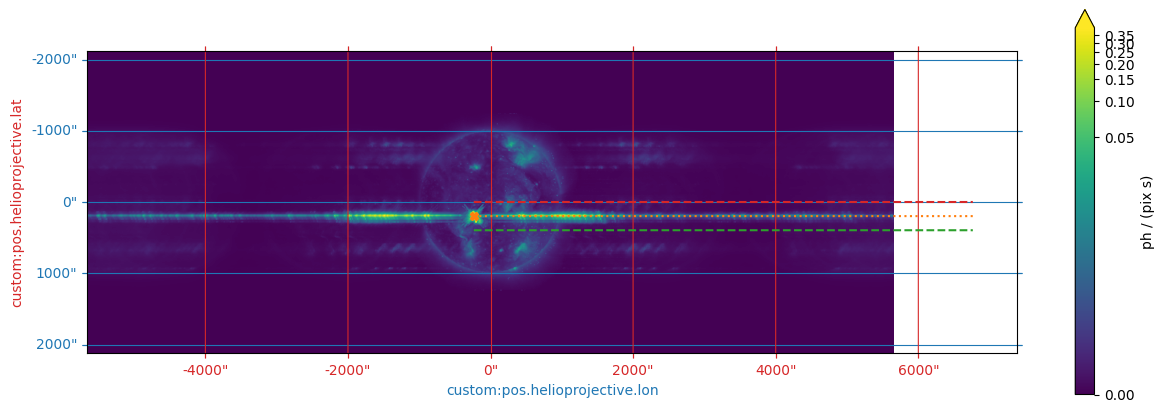

In [244]:
data_unit = u.Unit('photon / (pix s)')

fig = plt.figure(figsize=(15,5))
cropped_cube = total_overlappogram[0,:751,:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.99, lower_percentile=0, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
ax.plot_coord(flare_loc, color='C1', marker='X')
ax.plot(px,py, color='C1', ls=':')
ax.plot(px_lower, py_lower, color='C2', ls='--')
ax.plot(px_upper, py_upper, color='C3', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

In [245]:
iz_lower,iy_lower,ix_lower = overlappograms[1].wcs.world_to_array_index(flare_lower, wavelength_world)
in_bounds_x = np.logical_and(np.array(ix_lower)>=0,
                             np.array(ix_lower) <= (overlappograms[1].data.shape[-1] - 1))
in_bounds_y = np.logical_and(np.array(iy_lower)>=0,
                             np.array(iy_lower) <= (overlappograms[1].data.shape[1] - 1))
in_bounds = np.logical_and(in_bounds_x, in_bounds_y)
iz_lower = np.array(iz_lower)[in_bounds]
iy_lower = np.array(iy_lower)[in_bounds]
ix_lower = np.array(ix_lower)[in_bounds]

In [246]:
iz_upper,iy_upper,ix_upper = overlappograms[1].wcs.world_to_array_index(flare_upper, wavelength_world)
in_bounds_x = np.logical_and(np.array(ix_upper)>=0,
                             np.array(ix_upper) <= (overlappograms[1].data.shape[-1] - 1))
in_bounds_y = np.logical_and(np.array(iy_upper)>=0,
                             np.array(iy_upper) <= (overlappograms[1].data.shape[1] - 1))
in_bounds = np.logical_and(in_bounds_x, in_bounds_y)
iz_upper = np.array(iz_upper)[in_bounds]
iy_upper = np.array(iy_upper)[in_bounds]
ix_upper = np.array(ix_upper)[in_bounds]

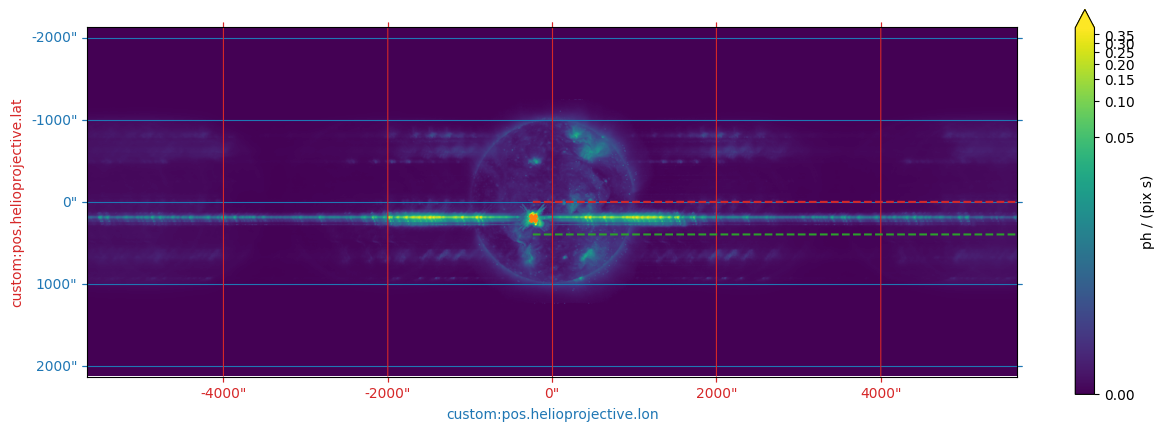

In [247]:
data_unit = u.Unit('photon / (pix s)')

fig = plt.figure(figsize=(15,5))
cropped_cube = total_overlappogram[0,:751,:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.99, lower_percentile=0, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
ax.plot_coord(flare_loc, color='C1', marker='X')
#ax.plot(px,py, color='C1', ls=':')
ax.plot(ix_lower, iy_lower, color='C2', ls='--')
ax.plot(ix_upper, iy_upper, color='C3', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

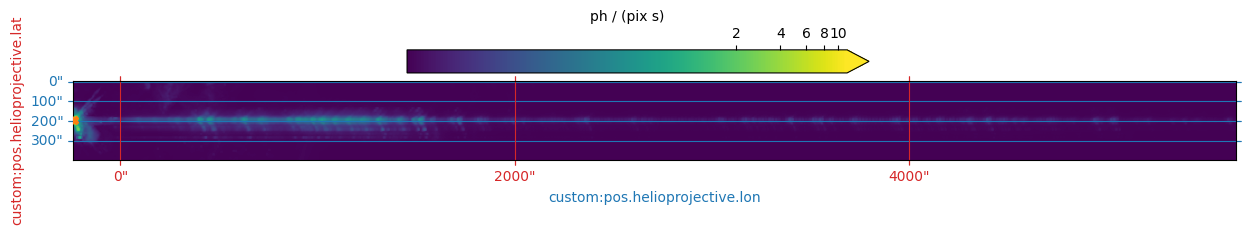

In [248]:
data_unit = u.Unit('photon / (pix s)')

fig = plt.figure(figsize=(15,2))
flare_region = total_overlappogram[0][np.min([iy_lower,iy_upper]):np.max([iy_lower, iy_upper])+1,
                                      np.min([ix_lower,ix_upper]):np.max([ix_lower, ix_upper])+1]

ax = fig.add_subplot(111, projection=flare_region.wcs)
flare_region.plot(
    axes=ax,
    norm=get_norm_from_percentile(flare_region.data*flare_region.unit, upper_percentile=99.99, lower_percentile=0, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
ax.plot_coord(flare_loc, color='C1', marker='X')
#ax.plot(px,py, color='C1', ls=':')
#ax.plot(ix_lower, iy_lower, color='C2', ls='--')
#ax.plot(ix_upper, iy_upper, color='C3', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max',orientation='horizontal', location='top')
cb.set_label(data_unit)

In [249]:
flare_region_0 = overlappograms[0][0][np.min([iy_lower,iy_upper]):np.max([iy_lower, iy_upper])+1,
                                      np.min([ix_lower,ix_upper]):np.max([ix_lower, ix_upper])+1]
flare_region_p1 = overlappograms[1][0][np.min([iy_lower,iy_upper]):np.max([iy_lower, iy_upper])+1,
                                       np.min([ix_lower,ix_upper]):np.max([ix_lower, ix_upper])+1]
flare_region_p3 = overlappograms[3][0][np.min([iy_lower,iy_upper]):np.max([iy_lower, iy_upper])+1,
                                       np.min([ix_lower,ix_upper]):np.max([ix_lower, ix_upper])+1]

In [250]:
coord, wave_flare_region = overlappograms[1].wcs.pixel_to_world(ix_lower, iy_lower, iz_lower)
coord, wave_flare_region_o3 = overlappograms[3].wcs.pixel_to_world(ix_lower, iy_lower, iz_lower)

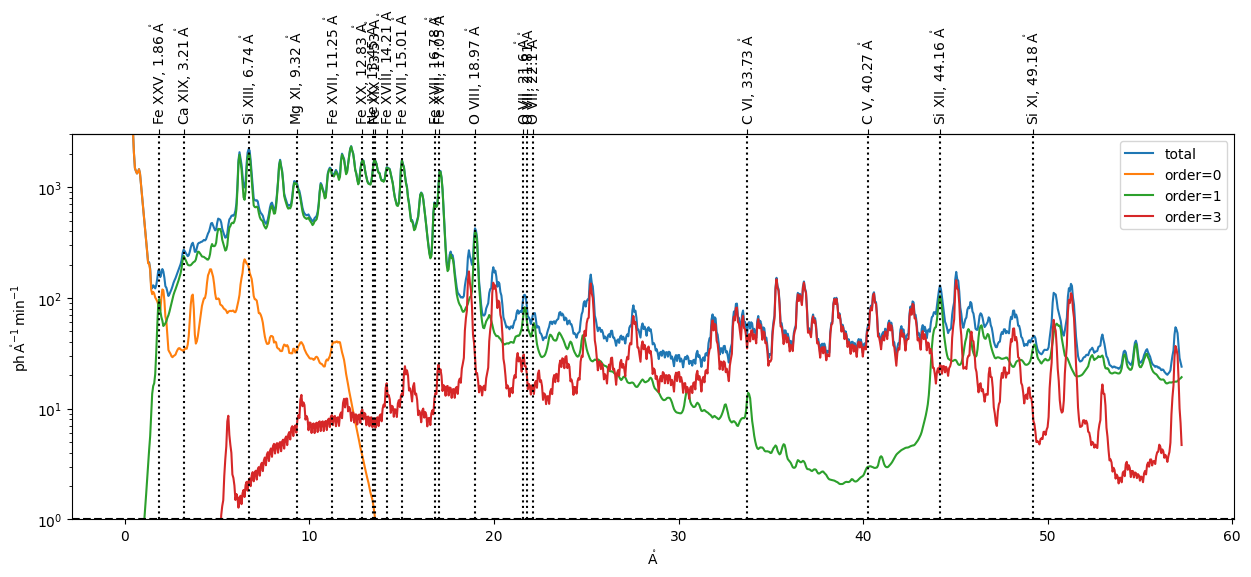

In [257]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
with quantity_support():
    ax.plot(wave_flare_region.to('Angstrom'),
            (flare_region.data.sum(axis=0)*flare_region.unit / dc.components[0].channel.spectral_resolution).to('ph minute-1 Angstrom-1'),
            label='total')
    ax.plot(wave_flare_region.to('Angstrom'),
            flare_region_0.data.sum(axis=0)*flare_region_0.unit/dc.components[0].channel.spectral_resolution,
            label='order=0')
    ax.plot(wave_flare_region.to('Angstrom'),
            flare_region_p1.data.sum(axis=0)*flare_region_p1.unit/dc.components[0].channel.spectral_resolution,
            label='order=1')
    ax.plot(wave_flare_region,
            flare_region_p3.data.sum(axis=0)*flare_region_p3.unit/dc.components[0].channel.spectral_resolution,
            label='order=3')
ax.set_yscale('log')
#ax.set_ylim(1,3e3)
ax.set_ylim(1, 3e3)
add_line_ids_to_axis(ax, line_ids,)
#ax.set_xlim(6,20)
ax.legend()
ax.axhline(y=1, color='k', ls='--')

In [318]:
iz,iy,ix = overlappograms[1].wcs.world_to_array_index(flare_loc, wavelength_world[:1000])

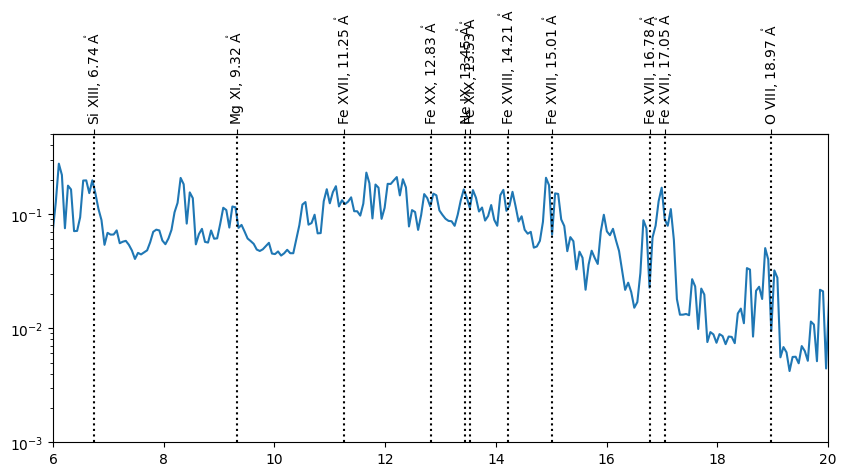

In [329]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
ax.plot(wavelength_world[:1000].to('AA'), total_overlappogram[0].data[iy,ix])
ax.set_yscale('log')
ax.set_ylim(.1e-2,.5)
ax.set_xlim(6,20)
add_line_ids_to_axis(ax, line_ids)

In [239]:
(np.pi * .5*u.R_sun).to('Mm')

<Quantity 1092.80300455 Mm>